In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
import acd
from tqdm import tqdm
import pickle as pkl
import torchvision
import models
import time
from functools import partial
sys.path.append('..')
sys.path.append('../..')
# plt.style.use('dark_background')
from visualize import *
import visualize as viz
from transforms_torch import bandpass_filter
from numpy.fft import *
from data import *
from style import *
data_path = './cosmo'
torch.manual_seed(42)
np.random.seed(42)

In [2]:
from acd_wooseok.acd.scores import cd

# load dataset and model

In [3]:
# params
img_size = 256
class_num = 1

In [4]:
# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                              oj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=64, shuffle=False, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, data_path=data_path).to(device)

# conv sparse coding

In [7]:
# import modules
from funcs import *
from matfac import *
torch.manual_seed(10)
X = iter(data_loader).next()['image'][0:1].to(device)

In [8]:
# set hyper-params and variables
n_components = 5
kernel_size = 7
n_dim = kernel_size + (img_size-1)

csc = Conv_SpCoding(kernel_size, n_dim, n_components).to(device)
# save init points
torch.save(csc.state_dict(), './model/csc_running1.pth')

# reg-parameter
lamb_cd = 1.
lamb = 0.015

# losses
n_inner = 20
losses = [1e+7]

# set optimizer
lr = 0.0005
param_list = [{'params': csc.convs.parameters(), 'lr': lr},
              {'params': csc.maps.parameters(), 'lr': lr}]
prox_list = [prox_normalization, partial(prox_soft_threshold, lamb=lr*lamb)]
optimizer = Optimizer(param_list, prox_list, momentum=0.0)

In [9]:
# run prox-SGD
n_epoch = 1000
for epoch in range(n_epoch):
    # update dict
    unfreeze(csc, param='dict')
    optimizer.zero_grad() # clear the old gradients
    # comp loss
    X_ = csc()
    loss = torch.norm(X-X_)**2/2  
    # backward
    loss.backward()
    # update step
    optimizer.step(0)    

    reg_loss = L1Reg_loss(csc, X, lamb)
    if reg_loss > losses[-1]:
        csc.load_state_dict(torch.load('./model/csc_running1.pth'))
        optimizer.param_groups[0]['lr'] *= 0.9
        losses.append(losses[-1])
    else:
        torch.save(csc.state_dict(), './model/csc_running1.pth')
        losses.append(reg_loss)    
    
    # update weight
    unfreeze(csc, param='map')
    # inner loop
    losses_inner = []
    for i in range(n_inner):
        optimizer.zero_grad() # clear the old gradients
        # comp loss
        X_ = csc()
        loss = torch.norm(X-X_)**2/2
        # backward
        loss.backward()
        # update step
        optimizer.step(1)    

        reg_loss = L1Reg_loss(csc, X, lamb)
        if reg_loss > losses[-1]:
            csc.load_state_dict(torch.load('./model/csc_running1.pth'))
            optimizer.param_groups[1]['lr'] *= 0.9
            optimizer.param_groups[1]['prox']  = partial(prox_soft_threshold, lamb=optimizer.param_groups[1]['lr']*lamb)
            losses.append(losses[-1])
        else:
            torch.save(csc.state_dict(), './model/csc_running1.pth')
            losses.append(reg_loss)           
        
    if epoch % 1 == 0:
        # recon-error, nnz
        err = torch.norm(X-X_).data.item() / torch.norm(X).data.item() 
        nnz = 0
        for feature_map in csc.maps:
            nnz += np.count_nonzero(feature_map.data.cpu().numpy())
        nnz_W = nnz/(n_dim*n_dim*n_components)
        
        print('\rTrain Epoch: {} [({:.0f}%)]\tError: {:.6f}\tLoss: [{:.6f}, {:.6f}, {:.6f}, {:.6f}]\tNNZ: {:.6f}%'.format(
            epoch, 100. * epoch / n_epoch, err, losses[-2-n_inner], losses[-1-n_inner], 
            losses[-n_inner], losses[-1], 100. * nnz_W), end='')          
        
    if epoch % 20 == 0:
        optimizer.param_groups[0]['lr'] *= 2
        optimizer.param_groups[1]['lr'] *= 2
        optimizer.param_groups[1]['prox']  = partial(prox_soft_threshold, lamb=optimizer.param_groups[1]['lr']*lamb)

Train Epoch: 999 [(100%)]	Error: 0.290984	Loss: [2.438178, 2.438178, 2.438176, 2.438161]	NNZ: 3.582250%

Text(0.5, 1.0, 'losses per epoch')

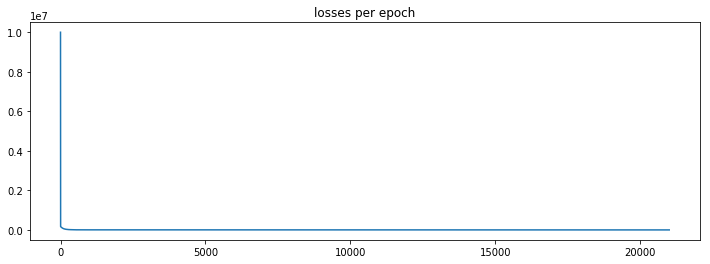

In [10]:
# plot losses
plt.figure(figsize=(12,4))
plt.plot((losses))
plt.title('losses per epoch')

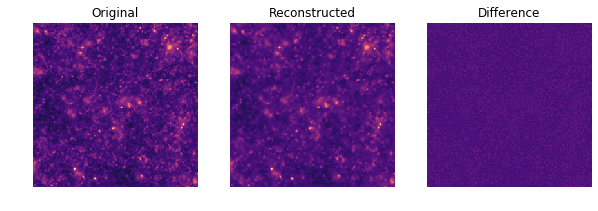

In [11]:
img = X.squeeze().cpu().data.numpy()
imgr = csc().squeeze().cpu().data.numpy()

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
cshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(1, 3, 2)
cshow(imgr)
plt.title('Reconstructed')
plt.axis('off')
plt.subplot(1, 3, 3)
cshow(img-imgr)
plt.title('Difference')
plt.axis('off')
plt.show()

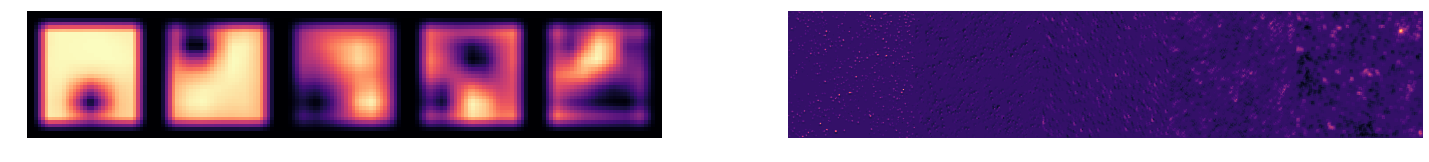

In [12]:
from skimage.transform import rescale

n_row = 1
n_col = n_components
Nimages = len(csc.convs)

plt.figure(figsize=(25,25))
# plot filters
plt.subplot(1, 2, 1)
p = kernel_size + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        im = csc.convs[indx].weight.data.cpu().squeeze().numpy()
        im = (im-np.min(im))
        im = im/np.max(im)
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im,(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')    

# plot each atom 
atoms = get_atoms(csc.convs, csc.maps)
plt.subplot(1, 2, 2)
p = img_size + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        im = atoms[indx].data.cpu().squeeze().numpy()
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im,(1,1),mode='constant',constant_values=0.)
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')
plt.show()        

# CD score

In [13]:
# compute cd-scores
scores = []
for comp_idx in range(n_components):
    with torch.no_grad():
        score = cd.cd(X, model, mask=None, model_type='resnet18', device='cuda', 
                transform=partial(conv_sparse_coder, atoms=atoms, comp_idx=[comp_idx]))[0].flatten()[class_num].item()
        scores.append(score)

In [14]:
activations = []
for param in csc.maps.parameters():
    activations.append(torch.abs(param.data).sum())

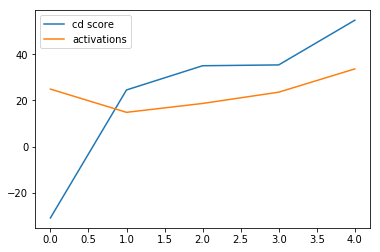

cd score for the residual: 0.09692414104938507


In [15]:
plt.plot(np.arange(n_components), 500*np.array(scores), label='cd score')
plt.plot(np.arange(n_components), activations, label='activations')
plt.legend()
plt.show()
with torch.no_grad():
    score = cd.cd(X, model, mask=None, model_type='resnet18', device='cuda', 
        transform=partial(get_residual, atoms=atoms))[0].flatten()[class_num].item()
print('cd score for the residual:', 1*score)

In [16]:
scores

[-0.06184084713459015,
 0.04912186041474342,
 0.07012344896793365,
 0.07082690298557281,
 0.10956872999668121]

# model inspection

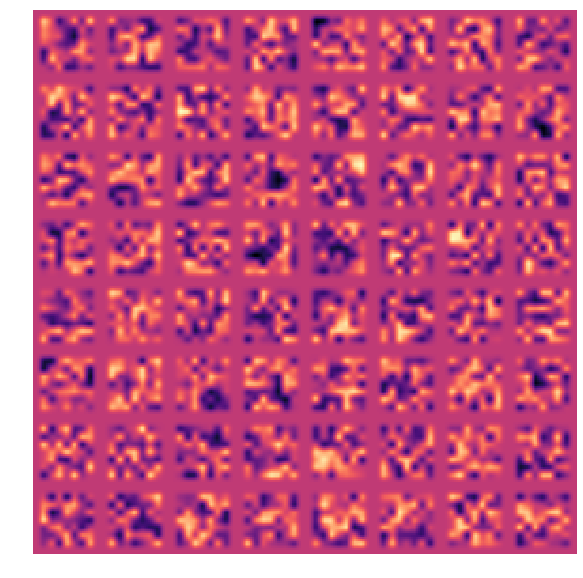

In [178]:
# plot of weights for the first conv layer
conv1_weights = []
for indx in range(64):
    conv1_weights.append(model.conv1.weight[indx].squeeze().cpu().detach().numpy())
    
plt.figure(figsize=(10,10))
n_row = 8
n_col = 8
p = 7 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
atoms = []
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(conv1_weights[indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')
plt.show()        

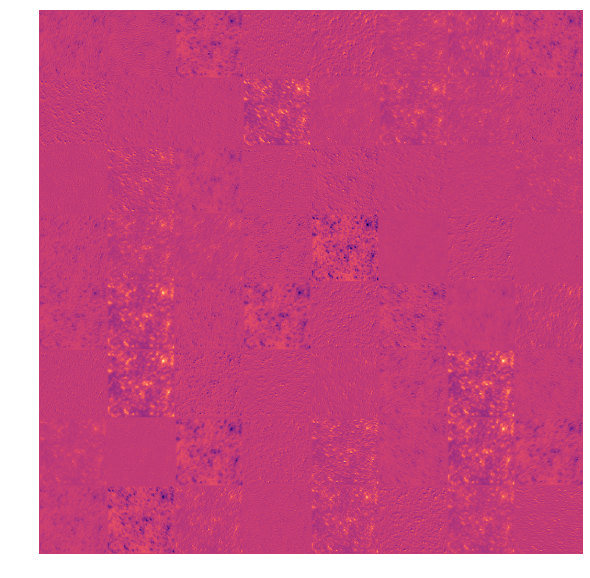

In [179]:
# plot of activation maps
feature_maps = model.conv1(X).data.cpu().detach().numpy().squeeze()

plt.figure(figsize=(10,10))
n_row = 8
n_col = 8
p = 128 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
atoms = []
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(feature_maps[indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')
plt.show()        